In [1]:
# Import core libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure visualization defaults
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

# Set color palette for consistency
colors = sns.color_palette("Set2")
sns.set_palette("Set2")

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


# Stadium Crowd Simulation - Exploratory Data Analysis

**Project**: Stadium Entry Flow Optimization using Machine Learning  
**Dataset**: SimPy discrete event simulation (68,000 fans, 14 gates, 600 minutes)  
**Objective**: Analyze crowd dynamics to predict congestion and optimize resource allocation

---

## Executive Summary

This notebook performs comprehensive exploratory data analysis on stadium simulation data to:
1. **Understand temporal patterns** in fan arrivals and completions
2. **Identify bottlenecks** in gate processing and resource utilization
3. **Analyze queue dynamics** across multiple gates
4. **Prepare ML-ready features** for congestion prediction models

**Key Insights**:
- Peak congestion occurs between t=140-240 min (22,000+ fans in queue)
- Gate utilization reaches 100% during rush periods
- Queue imbalance indicates potential for load redistribution
- Parking capacity exhausted at t=155 min

---

## 1. Setup and Configuration

## 2. Data Loading and Initial Inspection

Load the ML-optimized simulation dataset generated from SimPy discrete event simulation.

In [2]:
# Load simulation data
df = pd.read_csv("../data/raw/stadium_simulation.csv")

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} features")
print(f"Time Range: {df['time'].min():.0f} - {df['time'].max():.0f} minutes")
print(f"Total Fans: {df['fans_arrived'].max():,}")
print(f"\nFirst 5 rows:")
df.head()

Dataset Shape: 449 rows × 34 features
Time Range: 1 - 449 minutes
Total Fans: 68,000

First 5 rows:


,time,time_to_kickoff,is_pre_match,time_phase,fans_arrived,fans_completed,fans_exited,fans_in_stadium,fans_in_system,fill_ratio,...,est_wait_new_arrival,avg_vendor_wait,avg_exit_wait,max_exit_wait,arrival_rate_lag1,arrival_rate_lag5,arrival_rate_ma5,turnstiles_in_use,vendors_in_use,parking_free
0,1,179,1,0,89,0,0,0,89,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,89.00,2,0,5964
1,2,178,1,0,181,1,0,1,181,0.0000,...,0.0,0.0,0.0,0.0,89.0,0.0,90.50,2,1,5929
2,3,177,1,0,287,10,0,10,287,0.0001,...,0.0,0.0,0.0,0.0,92.0,0.0,95.67,3,1,5882
3,4,176,1,0,376,56,0,56,376,0.0008,...,0.0,0.0,0.0,0.0,106.0,0.0,94.00,4,3,5846
4,5,175,1,0,458,116,0,116,458,0.0017,...,0.0,0.0,0.0,0.0,89.0,0.0,91.60,1,6,5812


### Dataset Information and Statistics

In [3]:
# Display dataset info and summary statistics
print("="*60)
print("DATASET INFORMATION")
print("="*60)
df.info()

print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df.describe().round(2)

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time                   449 non-null    int64  
 1   time_to_kickoff        449 non-null    int64  
 2   is_pre_match           449 non-null    int64  
 3   time_phase             449 non-null    int64  
 4   fans_arrived           449 non-null    int64  
 5   fans_completed         449 non-null    int64  
 6   fans_exited            449 non-null    int64  
 7   fans_in_stadium        449 non-null    int64  
 8   fans_in_system         449 non-null    int64  
 9   fill_ratio             449 non-null    float64
 10  arrival_progress       449 non-null    float64
 11  exit_progress          449 non-null    float64
 12  arrival_rate           449 non-null    float64
 13  completion_rate        449 non-null    float64
 14  exit_rate              449 non-null   

,time,time_to_kickoff,is_pre_match,time_phase,fans_arrived,fans_completed,fans_exited,fans_in_stadium,fans_in_system,fill_ratio,...,est_wait_new_arrival,avg_vendor_wait,avg_exit_wait,max_exit_wait,arrival_rate_lag1,arrival_rate_lag5,arrival_rate_ma5,turnstiles_in_use,vendors_in_use,parking_free
count,449.00,449.00,449.00,449.00,449.00,449.00,449.00,449.00,449.00,449.00,...,449.0,449.0,449.0,449.0,449.00,449.00,449.00,449.00,449.00,449.00
mean,225.00,35.88,0.40,2.67,52924.84,52428.05,22354.36,30073.69,30570.48,0.77,...,0.0,0.0,0.0,0.0,151.45,151.45,151.85,6.37,11.52,2785.00
std,129.76,54.89,0.49,1.49,24796.41,25194.18,31322.31,30299.80,30338.97,0.37,...,0.0,0.0,0.0,0.0,283.22,283.22,280.05,12.17,21.71,2782.83
min,1.00,0.00,0.00,0.00,89.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00
25%,113.00,0.00,0.00,1.00,44230.00,41063.00,0.00,0.00,0.00,0.60,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00
50%,225.00,0.00,0.00,3.00,68000.00,68000.00,0.00,15149.00,16943.00,1.00,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,2242.00
75%,337.00,67.00,1.00,4.00,68000.00,68000.00,68000.00,67178.00,67399.00,1.00,...,0.0,0.0,0.0,0.0,101.00,101.00,101.20,9.00,8.00,6000.00
max,449.00,179.00,1.00,4.00,68000.00,68000.00,68000.00,68000.00,68000.00,1.00,...,0.0,0.0,0.0,0.0,1057.00,1057.00,1034.20,73.00,91.00,6000.00


---

## 3. Temporal Analysis

### 3.1 System Load Over Time

Analyze the accumulation and processing of fans throughout the simulation period.

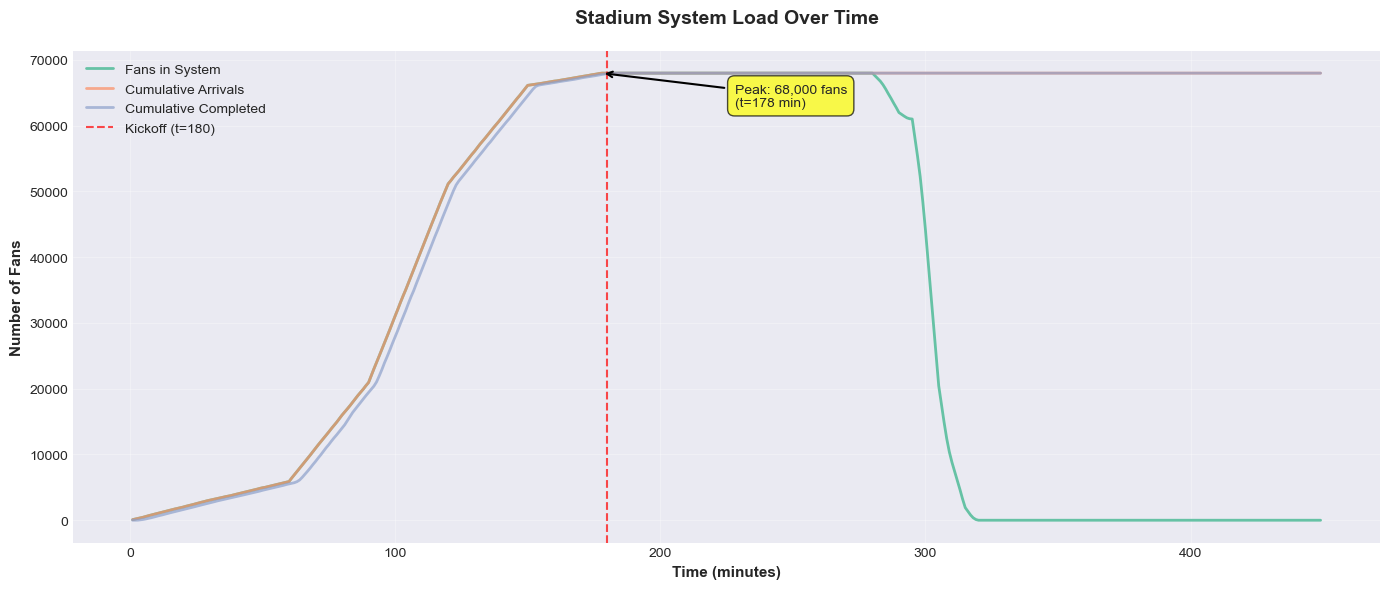

📊 Peak fans in system: 68,000 at t=178 minutes
📊 Final completion: 68,000 fans


In [4]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot system metrics
ax.plot(df["time"], df["fans_in_system"], label="Fans in System", linewidth=2, color=colors[0])
ax.plot(df["time"], df["fans_arrived"], label="Cumulative Arrivals", linewidth=2, alpha=0.7, color=colors[1])
ax.plot(df["time"], df["fans_completed"], label="Cumulative Completed", linewidth=2, alpha=0.7, color=colors[2])

# Add reference lines
kickoff = 180
ax.axvline(kickoff, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Kickoff (t={kickoff})')

# Styling
ax.set_xlabel("Time (minutes)", fontweight='bold')
ax.set_ylabel("Number of Fans", fontweight='bold')
ax.set_title("Stadium System Load Over Time", fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', framealpha=0.95)
ax.grid(True, alpha=0.3)

# Add statistics annotation
max_in_system = df['fans_in_system'].max()
time_max = df.loc[df['fans_in_system'].idxmax(), 'time']
ax.annotate(f'Peak: {max_in_system:,} fans\n(t={time_max:.0f} min)', 
            xy=(time_max, max_in_system), 
            xytext=(time_max+50, max_in_system-5000),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"📊 Peak fans in system: {max_in_system:,} at t={time_max:.0f} minutes")
print(f"📊 Final completion: {df['fans_completed'].iloc[-1]:,} fans")

### 3.2 Flow Analysis
**Stadium Lifecycle:** The simulation now tracks the complete stadium lifecycle - fans arriving, watching the match, and exiting. Net flow rate shows when the stadium is filling (positive) vs emptying (negative).

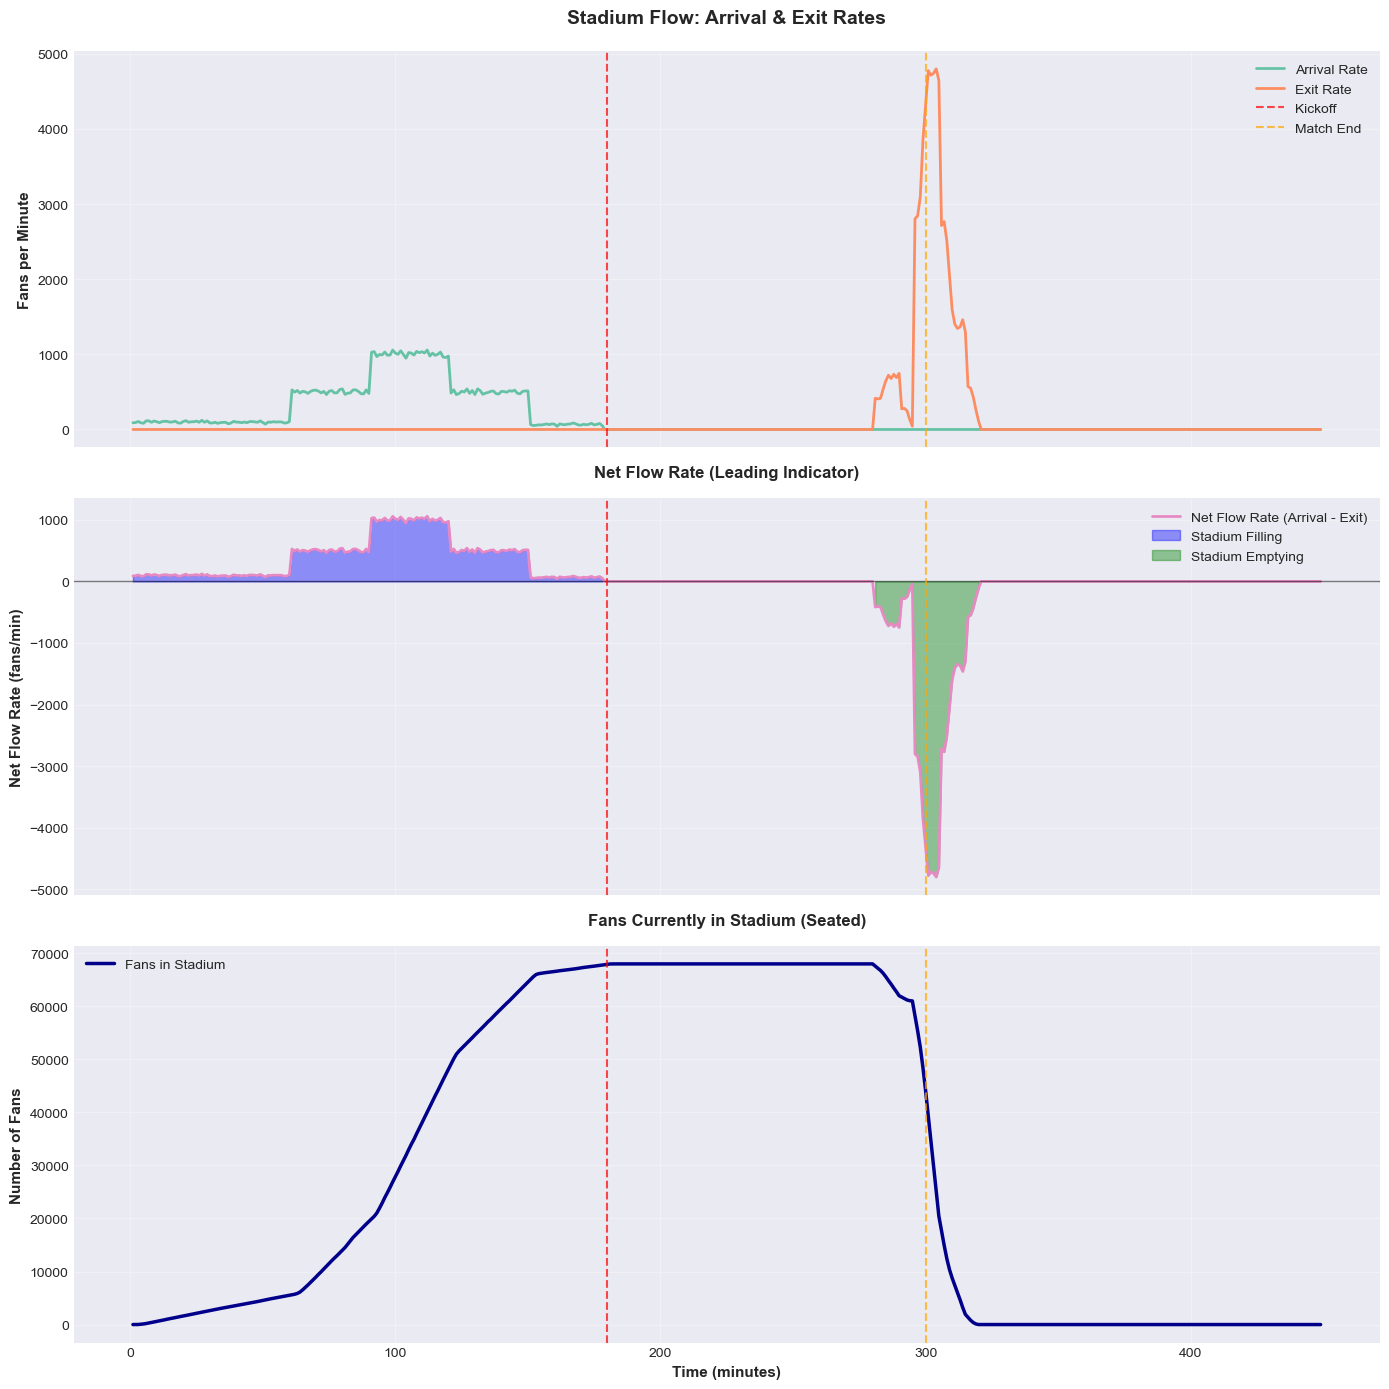

👥 Peak stadium occupancy: 68,000 fans at t=182 min
📥 Peak arrival rate: 1057 fans/min at t=99
📤 Peak exit rate: 4801 fans/min at t=304
✅ Final status: 68,000 fans exited, 0 remaining


In [5]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

# Top plot: Arrival vs Exit rates
ax1 = axes[0]
ax1.plot(df["time"], df["arrival_rate"], label="Arrival Rate", linewidth=2, color=colors[0])
ax1.plot(df["time"], df["exit_rate"], label="Exit Rate", linewidth=2, color=colors[1])
ax1.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Kickoff')
ax1.axvline(300, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Match End')
ax1.set_ylabel("Fans per Minute", fontweight='bold')
ax1.set_title("Stadium Flow: Arrival & Exit Rates", fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right', framealpha=0.95)
ax1.grid(True, alpha=0.3)

# Middle plot: Net flow rate (stadium filling/emptying)
ax2 = axes[1]
ax2.plot(df["time"], df["net_flow_rate"], label="Net Flow Rate (Arrival - Exit)", 
         linewidth=2, color=colors[3])
ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axvline(300, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.fill_between(df["time"], 0, df["net_flow_rate"], 
                  where=(df["net_flow_rate"] > 0), alpha=0.4, color='blue', label='Stadium Filling')
ax2.fill_between(df["time"], 0, df["net_flow_rate"], 
                  where=(df["net_flow_rate"] < 0), alpha=0.4, color='green', label='Stadium Emptying')
ax2.set_ylabel("Net Flow Rate (fans/min)", fontweight='bold')
ax2.set_title("Net Flow Rate (Leading Indicator)", fontsize=12, fontweight='bold', pad=15)
ax2.legend(loc='upper right', framealpha=0.95)
ax2.grid(True, alpha=0.3)

# Bottom plot: Fans in stadium over time
ax3 = axes[2]
ax3.plot(df["time"], df["fans_in_stadium"], label="Fans in Stadium", linewidth=2.5, color='darkblue')
ax3.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.axvline(300, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlabel("Time (minutes)", fontweight='bold')
ax3.set_ylabel("Number of Fans", fontweight='bold')
ax3.set_title("Fans Currently in Stadium (Seated)", fontsize=12, fontweight='bold', pad=15)
ax3.legend(loc='upper left', framealpha=0.95)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
max_in_stadium = df['fans_in_stadium'].max()
time_max = df.loc[df['fans_in_stadium'].idxmax(), 'time']
print(f"👥 Peak stadium occupancy: {max_in_stadium:,} fans at t={time_max:.0f} min")
print(f"📥 Peak arrival rate: {df['arrival_rate'].max():.0f} fans/min at t={df.loc[df['arrival_rate'].idxmax(), 'time']:.0f}")
print(f"📤 Peak exit rate: {df['exit_rate'].max():.0f} fans/min at t={df.loc[df['exit_rate'].idxmax(), 'time']:.0f}")
print(f"✅ Final status: {df['fans_exited'].iloc[-1]:,} fans exited, {df['fans_in_stadium'].iloc[-1]:,} remaining")

---

## 4. Queue and Congestion Analysis

### 4.1 Gate Queue Distribution and Load Balancing

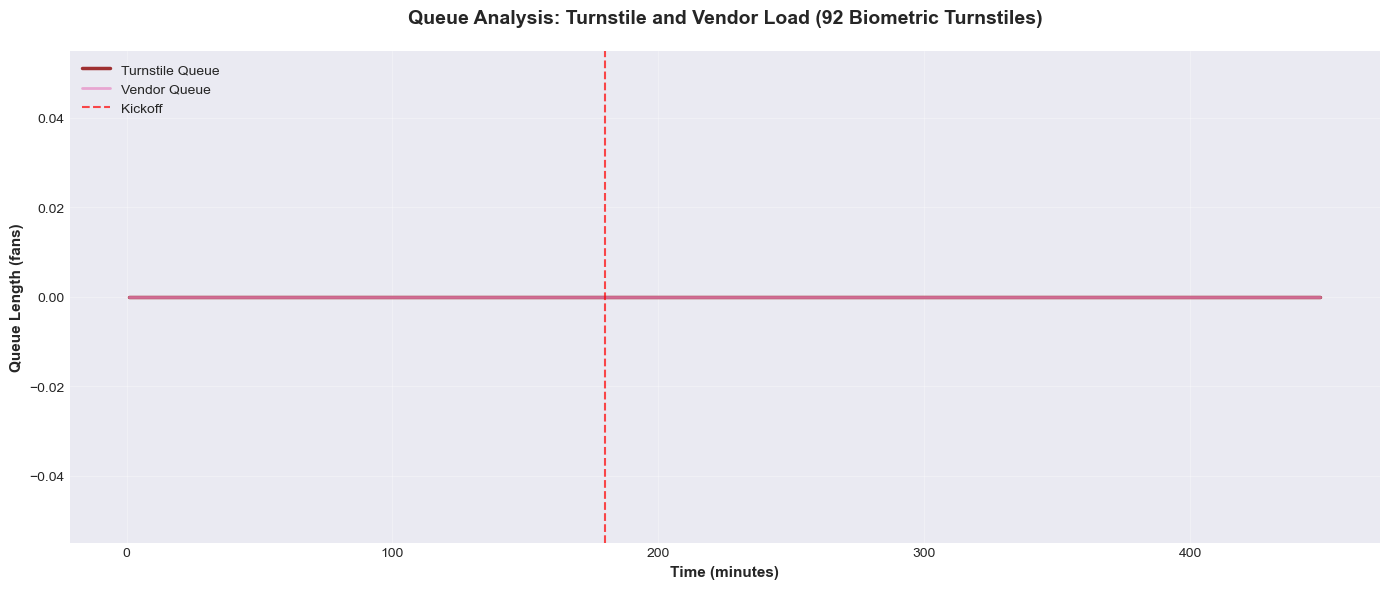

📊 Peak turnstile queue: 0 fans at t=1 min
📊 Peak vendor queue: 0 fans
📊 Max turnstile utilization: 79.3%


In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

# Turnstile queue (single shared resource, no per-gate breakdown)
ax1.plot(df["time"], df["turnstile_queue"], label="Turnstile Queue", linewidth=2.5, color='darkred', alpha=0.8)
ax1.plot(df["time"], df["vendor_queue"], label="Vendor Queue", linewidth=2, color=colors[3], alpha=0.7)
ax1.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Kickoff')
ax1.fill_between(df["time"], 0, df["turnstile_queue"], alpha=0.2, color='darkred')
ax1.set_xlabel("Time (minutes)", fontweight='bold')
ax1.set_ylabel("Queue Length (fans)", fontweight='bold')
ax1.set_title("Queue Analysis: Turnstile and Vendor Load (92 Biometric Turnstiles)", fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper left', framealpha=0.95)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Peak turnstile queue: {df['turnstile_queue'].max():,} fans at t={df.loc[df['turnstile_queue'].idxmax(), 'time']:.0f} min")
print(f"📊 Peak vendor queue: {df['vendor_queue'].max():,.0f} fans")
print(f"📊 Max turnstile utilization: {df['turnstile_utilization'].max()*100:.1f}%")

### 4.2 Resource Utilization Over Time

Modern biometric turnstiles enable fast processing - analyze utilization and throughput.

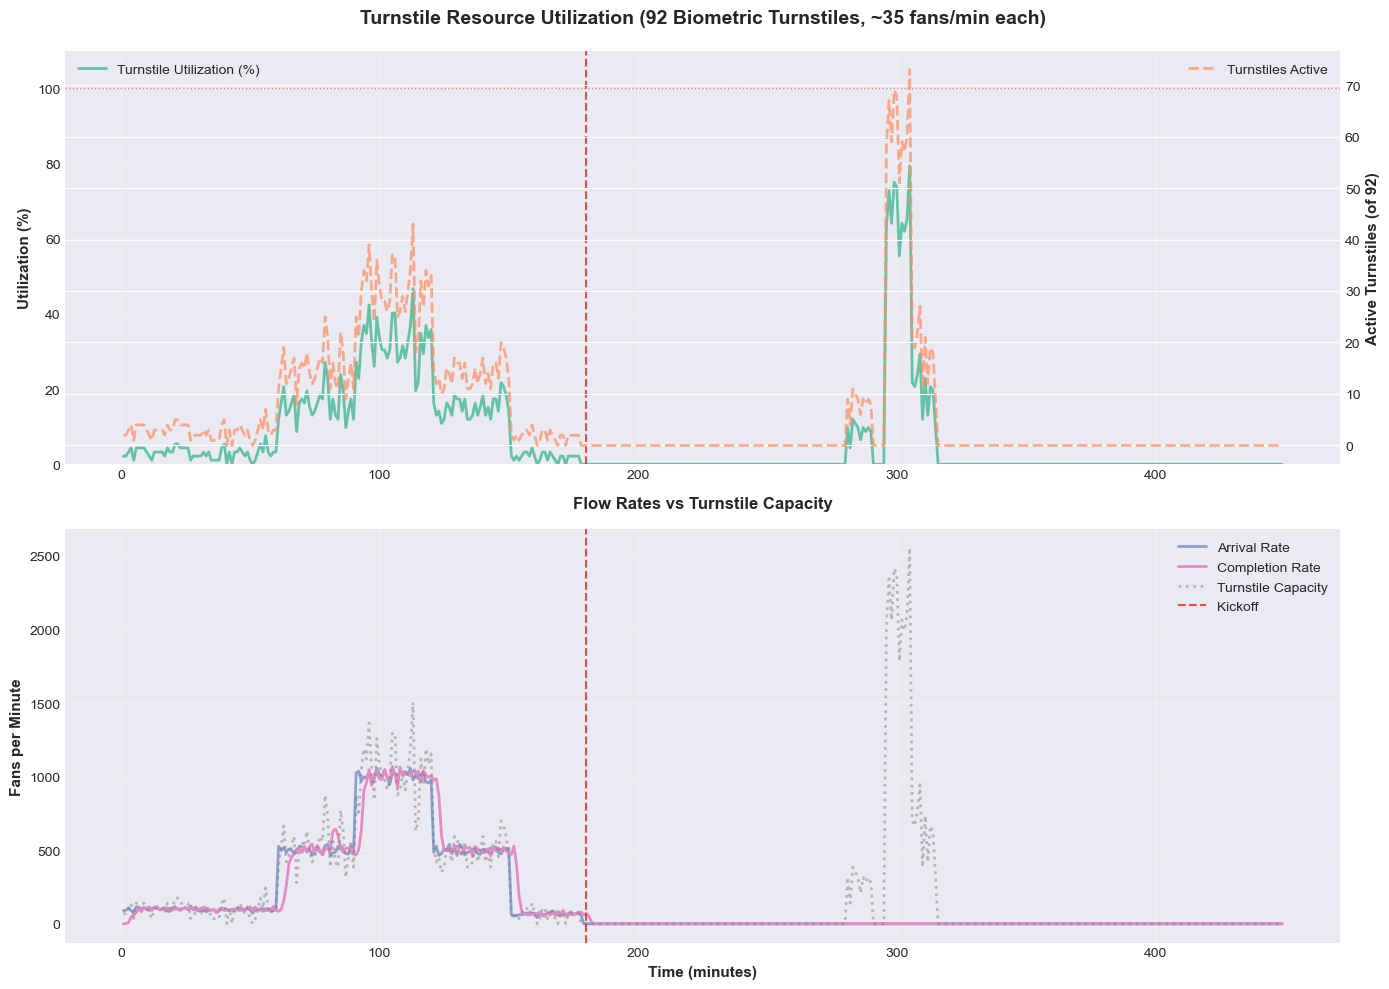


📊 Turnstile Performance Statistics:
  - Peak utilization: 79.3%
  - Avg utilization (during arrivals): 12.1%
  - Max active turnstiles: 73 of 92
  - Peak throughput: 1070 fans/min


In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top: Turnstile utilization and in-use count
ax1_twin = ax1.twinx()
ax1.plot(df["time"], df["turnstile_utilization"]*100, label="Turnstile Utilization (%)", 
         linewidth=2, color=colors[0])
ax1_twin.plot(df["time"], df["turnstiles_in_use"], label="Turnstiles Active", 
              linewidth=2, color=colors[1], alpha=0.7, linestyle='--')
ax1.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(100, color='red', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_ylabel("Utilization (%)", fontweight='bold')
ax1_twin.set_ylabel("Active Turnstiles (of 92)", fontweight='bold')
ax1.set_title("Turnstile Resource Utilization (92 Biometric Turnstiles, ~35 fans/min each)", 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper left', framealpha=0.95)
ax1_twin.legend(loc='upper right', framealpha=0.95)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 110)

# Bottom: Throughput capacity analysis
df_temp = df.copy()
df_temp['theoretical_capacity'] = df_temp['turnstiles_in_use'] * 35  # 35 fans/min per turnstile
ax2.plot(df_temp["time"], df_temp["arrival_rate"], label="Arrival Rate", linewidth=2, color=colors[2])
ax2.plot(df_temp["time"], df_temp["completion_rate"], label="Completion Rate", linewidth=2, color=colors[3])
ax2.plot(df_temp["time"], df_temp["theoretical_capacity"], label="Turnstile Capacity", 
         linewidth=2, color='gray', alpha=0.5, linestyle=':')
ax2.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Kickoff')
ax2.set_xlabel("Time (minutes)", fontweight='bold')
ax2.set_ylabel("Fans per Minute", fontweight='bold')
ax2.set_title("Flow Rates vs Turnstile Capacity", fontsize=12, fontweight='bold', pad=15)
ax2.legend(loc='upper right', framealpha=0.95)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Turnstile Performance Statistics:")
print(f"  - Peak utilization: {df['turnstile_utilization'].max()*100:.1f}%")
print(f"  - Avg utilization (during arrivals): {df[df['arrival_rate']>0]['turnstile_utilization'].mean()*100:.1f}%")
print(f"  - Max active turnstiles: {df['turnstiles_in_use'].max():.0f} of 92")
print(f"  - Peak throughput: {df['completion_rate'].max():.0f} fans/min")

### 4.3 Wait Times Analysis
**Biometric Turnstile Performance:** Modern biometric systems process 30-40 fans/min per turnstile. With 92 turnstiles, theoretical max throughput is ~3,220 fans/min. Wait times should remain under 5 minutes for optimal fan experience.

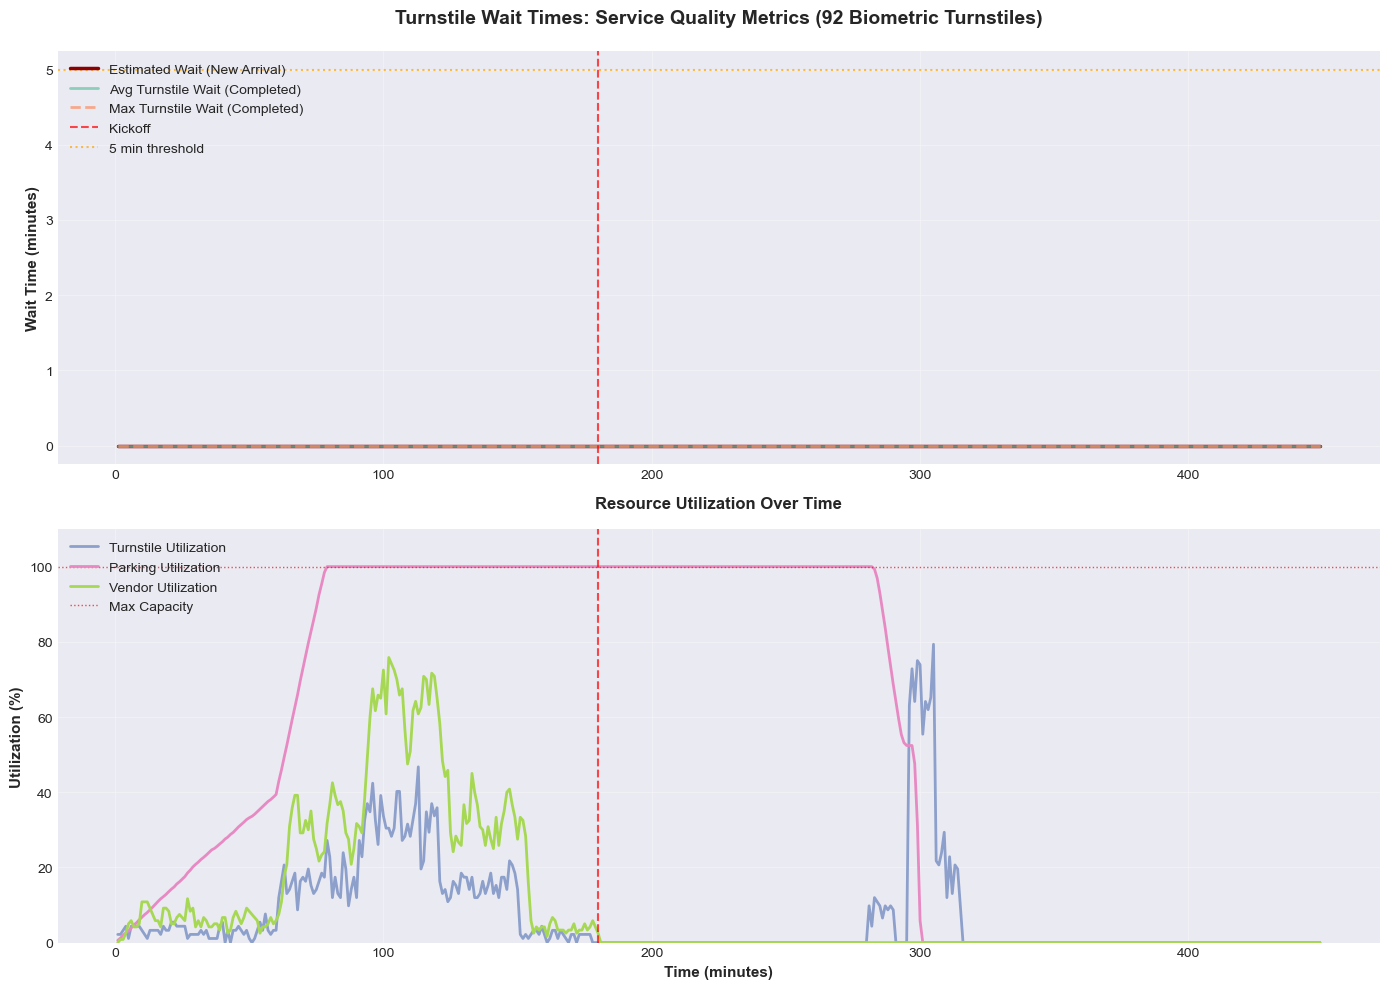

⏱️  Peak estimated wait: 0.0 minutes
⏱️  Average wait (overall): 0.0 minutes
📊 Turnstile utilization reaches 100%: Never
🅿️  Parking full: at t=79 min


In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top: Wait times
ax1.plot(df["time"], df["est_wait_new_arrival"], label="Estimated Wait (New Arrival)", 
         linewidth=2.5, color='darkred')
ax1.plot(df["time"], df["avg_turnstile_wait"], label="Avg Turnstile Wait (Completed)", 
         linewidth=2, color=colors[0], alpha=0.7)
ax1.plot(df["time"], df["max_turnstile_wait"], label="Max Turnstile Wait (Completed)", 
         linewidth=2, color=colors[1], alpha=0.7, linestyle='--')
ax1.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Kickoff')
ax1.axhline(5, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='5 min threshold')
ax1.set_ylabel("Wait Time (minutes)", fontweight='bold')
ax1.set_title("Turnstile Wait Times: Service Quality Metrics (92 Biometric Turnstiles)", fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper left', framealpha=0.95)
ax1.grid(True, alpha=0.3)

# Bottom: Resource utilization
ax2.plot(df["time"], df["turnstile_utilization"]*100, label="Turnstile Utilization", linewidth=2, color=colors[2])
ax2.plot(df["time"], df["parking_utilization"]*100, label="Parking Utilization", linewidth=2, color=colors[3])
ax2.plot(df["time"], df["vendor_utilization"]*100, label="Vendor Utilization", linewidth=2, color=colors[4])
ax2.axvline(180, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axhline(100, color='red', linestyle=':', linewidth=1, alpha=0.7, label='Max Capacity')
ax2.set_xlabel("Time (minutes)", fontweight='bold')
ax2.set_ylabel("Utilization (%)", fontweight='bold')
ax2.set_title("Resource Utilization Over Time", fontsize=12, fontweight='bold', pad=15)
ax2.legend(loc='upper left', framealpha=0.95)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 110)

plt.tight_layout()
plt.show()

print(f"⏱️  Peak estimated wait: {df['est_wait_new_arrival'].max():.1f} minutes")
print(f"⏱️  Average wait (overall): {df['avg_turnstile_wait'].mean():.1f} minutes")
max_util_time = df[df['turnstile_utilization']==1.0]['time'].min() if (df['turnstile_utilization']==1.0).any() else None
print(f"📊 Turnstile utilization reaches 100%: {'Never' if pd.isna(max_util_time) else f'at t={max_util_time:.0f} min'}")
parking_full_time = df[df['parking_utilization']==1.0]['time'].min() if (df['parking_utilization']==1.0).any() else None
print(f"🅿️  Parking full: {'Never' if pd.isna(parking_full_time) else f'at t={parking_full_time:.0f} min'}")

---

## 6. Feature Engineering for Machine Learning

### 6.1 Target Variable: Congestion Risk

Define a binary classification target for predicting high-congestion periods.

### 6.2 Feature Selection and Correlation Analysis

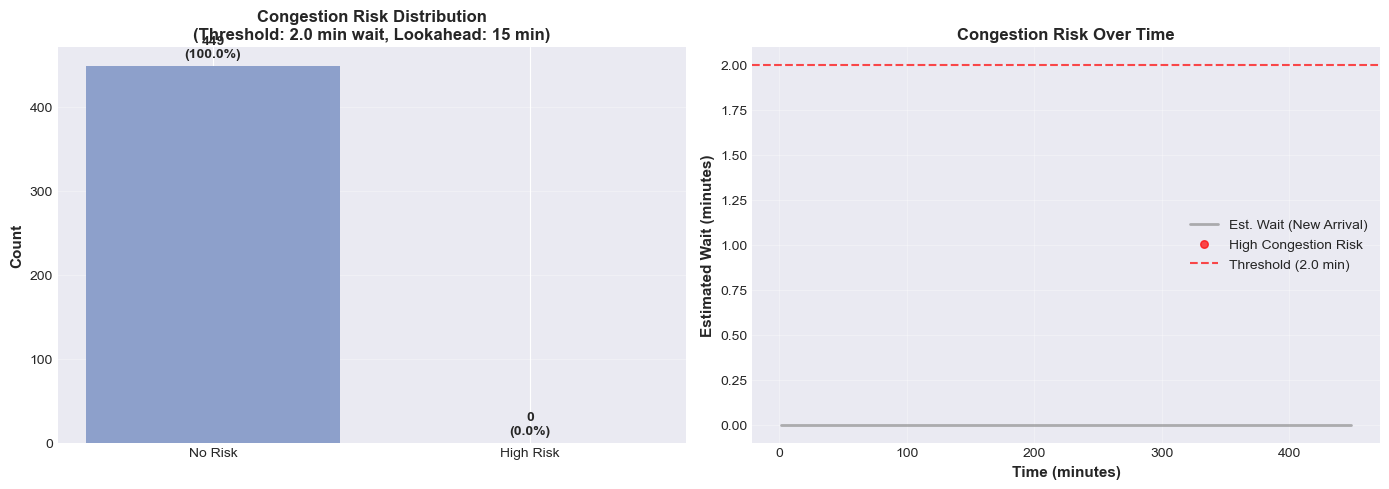

🎯 Target Variable Created:
   - Lookahead: 15 minutes
   - Threshold: 2.0 min wait
   - Class balance: 0.0% high-risk periods


In [9]:
# Create target variable: predict high wait times 15 minutes ahead
LOOKAHEAD_MINUTES = 15
WAIT_THRESHOLD = 2.0  # Wait > 2 minutes = congestion for biometric turnstiles

df['future_wait'] = df['est_wait_new_arrival'].shift(-LOOKAHEAD_MINUTES)
df['congestion_risk'] = (df['future_wait'] > WAIT_THRESHOLD).astype(int)

# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Target distribution
risk_counts = df['congestion_risk'].value_counts()
ax1.bar(['No Risk', 'High Risk'], [risk_counts.get(0, 0), risk_counts.get(1, 0)], 
        color=[colors[2], colors[0]])
ax1.set_ylabel("Count", fontweight='bold')
ax1.set_title(f"Congestion Risk Distribution\n(Threshold: {WAIT_THRESHOLD} min wait, Lookahead: {LOOKAHEAD_MINUTES} min)", 
              fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for i, (label, count) in enumerate(zip(['No Risk', 'High Risk'], [risk_counts.get(0, 0), risk_counts.get(1, 0)])):
    ax1.text(i, count + 10, f'{count}\n({count/len(df)*100:.1f}%)', 
             ha='center', fontweight='bold')

# Right: Temporal distribution
ax2.plot(df['time'], df['est_wait_new_arrival'], label='Est. Wait (New Arrival)', linewidth=2, color='gray', alpha=0.6)
risk_times = df[df['congestion_risk'] == 1]['time']
ax2.scatter(risk_times, df.loc[df['congestion_risk'] == 1, 'est_wait_new_arrival'], 
            color='red', s=30, alpha=0.7, label='High Congestion Risk', zorder=5)
ax2.axhline(WAIT_THRESHOLD, color='red', linestyle='--', linewidth=1.5, alpha=0.7, 
            label=f'Threshold ({WAIT_THRESHOLD} min)')
ax2.set_xlabel("Time (minutes)", fontweight='bold')
ax2.set_ylabel("Estimated Wait (minutes)", fontweight='bold')
ax2.set_title("Congestion Risk Over Time", fontweight='bold')
ax2.legend(framealpha=0.95)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"🎯 Target Variable Created:")
print(f"   - Lookahead: {LOOKAHEAD_MINUTES} minutes")
print(f"   - Threshold: {WAIT_THRESHOLD} min wait")
print(f"   - Class balance: {risk_counts.get(1, 0)/len(df)*100:.1f}% high-risk periods")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

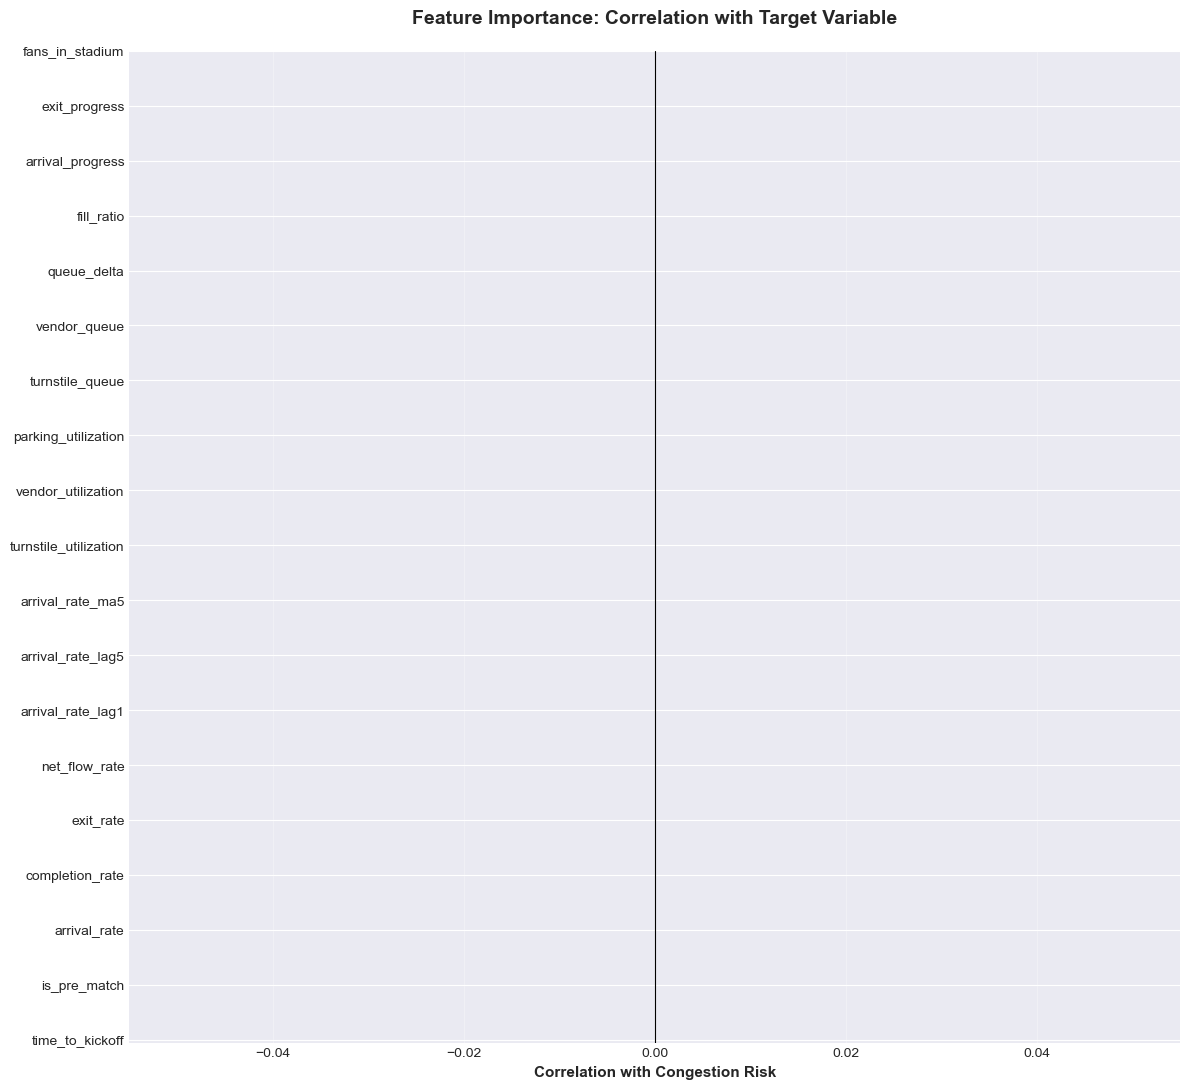


📊 ML Dataset Summary:
   - Samples: 449
   - Features: 19
   - Target: congestion_risk

🔝 Top 5 Predictive Features:
   1. time_to_kickoff: nan
   2. is_pre_match: nan
   3. arrival_rate: nan
   4. completion_rate: nan
   5. exit_rate: nan


In [10]:
# Select ML features (exclude identifiers, targets, and derived features)
feature_cols = [
    # Temporal features
    'time_to_kickoff',
    'is_pre_match',
    
    # Rate features (key predictors)
    'arrival_rate',
    'completion_rate',
    'exit_rate',
    'net_flow_rate',
    
    # Lag features (time series context)
    'arrival_rate_lag1',
    'arrival_rate_lag5',
    'arrival_rate_ma5',
    
    # Utilization features (capacity constraints)
    'turnstile_utilization',
    'vendor_utilization',
    'parking_utilization',
    
    # Queue features (current state)
    'turnstile_queue',
    'vendor_queue',
    'queue_delta',
    
    # Progress features
    'fill_ratio',
    'arrival_progress',
    'exit_progress',
    
    # Stadium occupancy
    'fans_in_stadium'
]

# Create ML dataset
ml_df = df[feature_cols + ['congestion_risk']].dropna()

# Correlation analysis
fig, ax = plt.subplots(figsize=(12, 11))
correlation_matrix = ml_df[feature_cols].corrwith(ml_df['congestion_risk']).sort_values(ascending=False)

# Plot correlation with target
colors_corr = ['green' if x > 0 else 'red' for x in correlation_matrix]
ax.barh(range(len(correlation_matrix)), correlation_matrix.values, color=colors_corr, alpha=0.7)
ax.set_yticks(range(len(correlation_matrix)))
ax.set_yticklabels(correlation_matrix.index, fontsize=10)
ax.set_xlabel("Correlation with Congestion Risk", fontweight='bold')
ax.set_title("Feature Importance: Correlation with Target Variable", fontsize=14, fontweight='bold', pad=20)
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add correlation values
for i, v in enumerate(correlation_matrix.values):
    ax.text(v + 0.02 if v > 0 else v - 0.02, i, f'{v:.3f}', 
            va='center', ha='left' if v > 0 else 'right', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 ML Dataset Summary:")
print(f"   - Samples: {len(ml_df):,}")
print(f"   - Features: {len(feature_cols)}")
print(f"   - Target: congestion_risk")
print(f"\n🔝 Top 5 Predictive Features:")
for i, (feat, corr) in enumerate(correlation_matrix.head().items(), 1):
    print(f"   {i}. {feat}: {corr:.3f}")

---

## 7. Data Export for ML Pipeline

Save processed datasets for model training and evaluation.

In [11]:
# Export cleaned full dataset
df.to_csv("../data/processed/stadium_clean.csv", index=False)
print(f"✅ Exported: stadium_clean.csv ({df.shape[0]} rows × {df.shape[1]} columns)")

# Export ML-ready feature dataset
ml_df.to_csv("../data/processed/stadium_features.csv", index=False)
print(f"✅ Exported: stadium_features.csv ({ml_df.shape[0]} rows × {ml_df.shape[1]} columns)")

# Export feature metadata
feature_metadata = pd.DataFrame({
    'feature': feature_cols,
    'correlation': [ml_df[f].corr(ml_df['congestion_risk']) for f in feature_cols],
    'mean': [ml_df[f].mean() for f in feature_cols],
    'std': [ml_df[f].std() for f in feature_cols],
    'min': [ml_df[f].min() for f in feature_cols],
    'max': [ml_df[f].max() for f in feature_cols]
})
feature_metadata = feature_metadata.sort_values('correlation', key=abs, ascending=False)
feature_metadata.to_csv("../data/processed/feature_metadata.csv", index=False)
print(f"✅ Exported: feature_metadata.csv (feature documentation)")

print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)
print(f"📁 Output files ready in: data/processed/")
print(f"   1. stadium_clean.csv - Full cleaned dataset")
print(f"   2. stadium_features.csv - ML features + target")
print(f"   3. feature_metadata.csv - Feature documentation")
print("\n🚀 Ready for model training!")

✅ Exported: stadium_clean.csv (449 rows × 36 columns)
✅ Exported: stadium_features.csv (449 rows × 20 columns)
✅ Exported: feature_metadata.csv (feature documentation)

DATA PREPARATION COMPLETE
📁 Output files ready in: data/processed/
   1. stadium_clean.csv - Full cleaned dataset
   2. stadium_features.csv - ML features + target
   3. feature_metadata.csv - Feature documentation

🚀 Ready for model training!
